In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats

import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pylab as plt
plt.style.use('ggplot')


In [45]:
scaling_factor = 1000000000000

In [3]:
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [13]:
column_names_apartments = ['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'price']
column_names_buildings = ['new', 'latitude', 'longitude', 'district', 'street', 'address',
       'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating']
all_features = column_names_apartments[:-1] + column_names_buildings

In [14]:
def preprocess(data,price_outlier_rejection=False,fill=True):
    if price_outlier_rejection is True:
        data = data[(np.abs(stats.zscore(data['price'])) < 3.9)]
    if fill is True:
        return data.fillna(data.mean())
    else:
        return data.dropna()

In [19]:
processed_data = preprocess(train)

In [37]:
X = processed_data[all_features]
X = X.drop(['street', 'address'], axis=1)
y = processed_data['price']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adaboost

In [41]:
adaboost = AdaBoostRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    loss='square',
    random_state=42
)

In [42]:
adaboost.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, loss='square', n_estimators=1500,
                  random_state=42)

In [43]:
ada_prediction = adaboost.predict(X_test)

In [46]:
ada_mse = round(mean_squared_error(ada_prediction, y_test), 2)
print('Test MSE:', ada_mse/scaling_factor)

Test MSE: 10972.585579043702


Text(0, 0.5, 'Ground Truth')

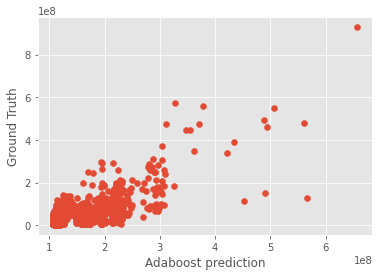

In [47]:
plt.scatter(ada_prediction, y_test)
plt.xlabel('Adaboost prediction')
plt.ylabel('Ground Truth')

# Gradient Boosting Machine

In [48]:
grad_boost_regr = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [49]:
grad_boost_regr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.01, max_depth=9,
                          min_samples_leaf=2, min_samples_split=4,
                          n_estimators=2000, random_state=0)

In [50]:
gb_prediction = grad_boost_regr.predict(X_test)

In [54]:
gb_mse = round(mean_squared_error(gb_prediction, y_test), 2)
print('Test MSE:', gb_mse/scaling_factor)

Test MSE: 253.9940319389967


Text(0, 0.5, 'Ground Truth')

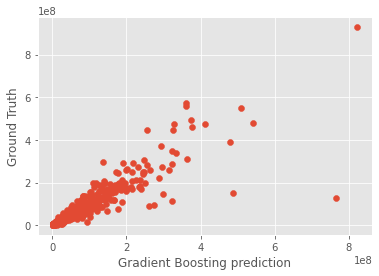

In [52]:
plt.scatter(gb_prediction, y_test)
plt.xlabel('Gradient Boosting prediction')
plt.ylabel('Ground Truth')

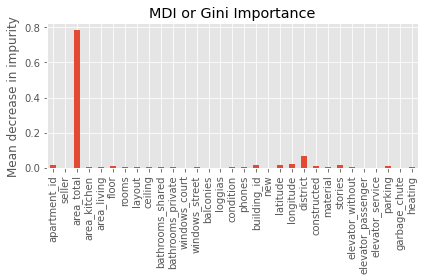

In [53]:
importances = grad_boost_regr.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# LightGBM

In [55]:
light_gbm = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=2000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

In [56]:
light_gbm.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.95, learning_rate=0.05, max_depth=5,
              metric='mse', n_estimators=2000, n_jobs=4, num_leaves=10,
              random_state=42, subsample=0.9)

In [57]:
lgbm_prediction = light_gbm.predict(X_test)

In [58]:
lgb_mse = round(mean_squared_error(lgbm_prediction, y_test), 2)
print('Test MSE:', lgb_mse/scaling_factor)

Test MSE: 303.60745617994456


Text(0, 0.5, 'Ground Truth')

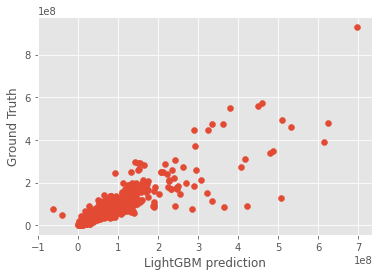

In [59]:
plt.scatter(lgbm_prediction, y_test)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')

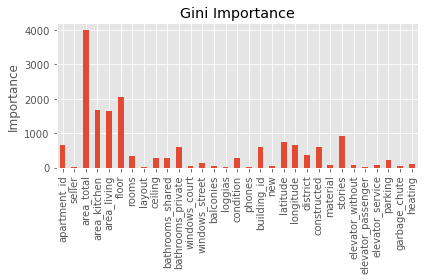

In [60]:
importances = light_gbm.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

# CatBoost

In [61]:
model6 = CatBoostRegressor(
    n_estimators=500,
    learning_rate=0.1,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [62]:
model6.fit(X_train, y_train)

In [63]:
cat_prediction = model6.predict(X_test)

In [66]:
cat_mse = round(mean_squared_error(cat_prediction, y_test), 2)
print('Test MSE:', cat_mse/scaling_factor)

Test MSE: 444.99195252694983


Text(0, 0.5, 'Ground Truth')

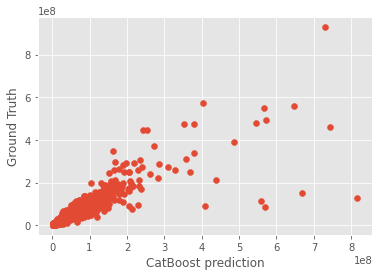

In [65]:
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

# Stacking